In [53]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from aml_utils import test_case_checker, perform_computation

Libraries such as `math` are neither as accurate nor as efficient as `numpy`.

**Note**: Do not import or use any other libraries other than what is already imported above. 

# *Assignment Summary

The UCI collection includes a set about authenticating banknotes donated by Volker Lohweg and Helene Doerksen at http://archive.ics.uci.edu/ml/datasets/banknote+authentication . This is a low-dimensional data set including only 4 features without any missing data points. To make things more interesting, you can adverserially augment the data with a large amount of noise features (say 5000 noise features), and see how SVM and different regularization schemes perform.

Write a program to train a support vector machine on this data using stochastic gradient descent.  These are some constraints to consider:

  * Do not use a package to train the classifier (that's the point), but your own code.
    
  * Scale the variables so that each has unit variance. 
    
  * Search for an appropriate value of the regularization constant, trying at least the values [1e-3, 1e-2, 1e-1, 1]. Use the validation set for this search.
    
  * Use at least 50 epochs of at least 300 steps each. In each epoch, you should separate out 50 training examples at random for evaluation (call this the set held out for the epoch). 
    
  * Compute the accuracy of the current classifier on the set held out for the epoch every 30 steps. 
    
You should produce:

  * A plot of the accuracy every 30 steps, for each value of the regularization constant.
  
  * A plot of the magnitude of the coefficient vector every 30 steps, for each value of the regularization constant.
  
  * Your estimate of the best value of the regularization constant, together with a brief description of why you believe that is a good value.
  
  * Your estimate of the accuracy of the best classifier on the test dataset data
  
**References:**

  * Textbook sections 2.1 - 2.2: https://link-springer-com.proxy2.library.illinois.edu/chapter/10.1007/978-3-030-18114-7_2

# 0. Normalizing the Features

# <span style="color:blue">Task 1</span>

Write a function ```normalize_feats``` that takes the following arguments:

1. `train_features`: A numpy array with the shape $(N_{\text{train}}, d)$, where $d$ is the number of features and $N_{\text{train}}$ is the number of training samples. 
2. ```some_features```: A numpy array with the shape $(N_{\text{some}}, d)$, where $d$ is the number of features and $N_{\text{some}}$ is the number of samples to be normalized. 
    
    * Do not assume anything about the values of $N_{\text{train}}, N_{\text{some}}, d$; they could be anything in the test cases.
    
and does the following:

1. Find the $\mu_{\text{train}}$, which is the training set average of the features. $\mu_{\text{train}}$ Should have $d$ elements.
2. Find the $\sigma_{\text{train}}$, which is the training set standard deviation of the features. $\sigma_{\text{train}}$ Should have $d$ elements.
4. For each row $x$ in `some_features`, define the equivalent row $\hat{x}$ in `some_features_normalized` to be $\hat{x} = \frac{x - \mu_{\text{train}}}{\sigma_{\text{train}}}$ with the subtraction and division operation defined in an element-wise manner.

The function should return the numpy array `some_features_normalized` whose shape is $(N_{\text{some}}, d)$.

In [54]:
def normalize_feats(train_features, some_features):
    """
    Normalizes the sample data features.
    
    Parameters
    ----------
    train_features: A numpy array with the shape (N_train, d), where d is the number of features and N_train is the number of training samples.
    some_features: A numpy array with the shape (N_some, d), where d is the number of features and N_some is the number of samples to be normalized.
    
    Returns
    -------
    some_features_normalized: A numpy array with shape (N_some, d).
    """
    
    # your code here
    mean = np.mean(train_features,axis=0)
    std = np.std(train_features,axis=0)
    some_features_normalized = np.array([(some_features[n, :] - mean) / std for n in range(some_features.shape[0])])
    
    # raise NotImplementedErro
    return some_features_normalized

In [55]:
# Performing sanity checks on your implementation
X_train = (np.arange(35).reshape(5,7) ** 13) % 20
X_some = np.arange(7).reshape(1,7) * 10
X_norm_some = normalize_feats(X_train, X_some)
assert np.array_equal(X_norm_some.round(3), np.array([[-1.265,  0.04 ,  2.298,  3.24 ,  9.247,  6.798,  8.056]]))

# Checking against the pre-computed test database
test_results = test_case_checker(normalize_feats, task_id=1)
assert test_results['passed'], test_results['message']

In [56]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# 1. The Support Vector Machine

## 1.1 Implementing the Utility Functions for SVM

# <span style="color:blue">Task 2</span>

Write a function ```e_term``` that takes the following arguments:

1. `x_batch`: A numpy array with the shape $(N, d)$, where $d$ is the number of features and $N$ is the batch size. 
2. `y_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. 
2. `a`: A numpy array with the shape $(d, 1)$, where $d$ is the number of features. This is the weight vector.
2. `b`: A scalar. 
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
and returns the numpy array `e_batch` whose shape is $(N,1)$ and is defined as the following:

* If the $k^{th}$ row of `x_batch`, `y_batch`, and `e_batch` were to be denoted as $x^{(k)}$, $y_k$ and $e_k$, respectively, then we have $e_k= 1- y_k (a\cdot x^{(k)}+b)$, where $a\cdot x^{(k)}$ is the dot product of the vectors $a$ and $x^{(k)}$.

It may be a good thought exercise to implement this function without utilizing `for` loops. In fact, it's easier, more efficient, and possible in a single line.

In [57]:
def e_term(x_batch, y_batch, a, b):
    """
    Computes the margin of the data points.
    
    Parameters
    ----------
    x_batch: A numpy array with the shape (N, d), where d is the number of features and N is the batch size.
    y_batch: A numpy array with the shape (N, 1), where N is the batch size.
    a: A numpy array with the shape (d, 1), where d is the number of features. This is the weight vector.
    b: A scalar.
    
    Returns
    -------
    e_batch: A numpy array with shape (N, 1). 
    """
    
    # your code here
    e_batch = np.array([1 - y_batch[n] * (np.dot(a.reshape(x_batch[n].shape), x_batch[n]) + b) for n in range(x_batch.shape[0])])
    
    # raise NotImplementedError
    
    return e_batch

In [58]:
# Performing sanity checks on your implementation
x_batch_ = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
y_batch_ = (2. * (np.arange(5)>2) - 1.).reshape(-1,1)
a_ = (np.arange(7)* 0.2).reshape(-1,1)
b_ = 0.1
e_batch_ = e_term(x_batch_, y_batch_, a_, b_)

assert np.array_equal(e_batch_.round(3), np.array([[ 5.986],[ 7.043],[ 7.529],[-4.014],[-1.7  ]]))

# Checking against the pre-computed test database
test_results = test_case_checker(e_term, task_id=2)
assert test_results['passed'], test_results['message']

In [59]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 3</span>

Write a function ```loss_terms_ridge``` that computes the hinge and ridge regularization losses. The `loss_terms_ridge` functions should take the following arguments:

1. `e_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. This is the output of the `e_term` function you wrote previously, and its $k^{(th)}$ element is $e_k= 1- y_k (a\cdot x^{(k)}+b)$.
2. `a`: A numpy array with the shape $(d, 1)$, where $d$ is the number of features. This is the weight vector.
3. `lam`: A scalar representing the regularization coefficient $\lambda$. 
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
and return the following two scalars:

1. `hinge_loss`: This hinge loss is defined as $l_{\text{hinge}} = \frac{1}{N}\sum_{i=1}^{N} \max(0, 1- y_i (a\cdot x^{(i)}+b))$. This can easily be written as a function of `e_batch`.
2. `ridge_loss`: This ridge regularization loss is defined as $l_{\text{ridge}} = \frac{\lambda}{2} \|a\|_2^2 = \frac{\lambda}{2} a^Ta$.

You should produce both `hinge_loss` and `ridge_loss`. 
* Make sure that both of them are scalars and not multi-element arrays. 
* It may be a good thought exercise to implement this function without utilizing `for` loops. You only need a single line for each term.

In [123]:
def loss_terms_ridge(e_batch, a, lam):
    """
    Computes the hinge and ridge regularization losses.
    
    Parameters
    ----------
    e_batch: A numpy array with the shape (N, 1), where N is the batch size. This is the output of the e_term function you wrote previously, and its kth element is e_k = 1 − y_k(a*x_k+b).
    a: A numpy array with the shape (d, 1), where d is the number of features. This is the weight vector.
    lam: A scalar representing the regularization coefficient 𝜆.
    
    Returns
    -------
    hinge_loss: The hinge regularization loss defined in the above cell.
    ridge_loss: The ridge regularization loss defined in the above cell.
    """
    
    # your code here
    N = e_batch.shape[0]
    hinge_loss = 1 / N * np.sum(np.fmax(0, e_batch))
    # ridge_loss = lam / 2 * a.T @ a
    ridge_loss = lam / 2 * np.square(np.linalg.norm(a, 2))
    
    # raise NotImplementedError
    
    return np.array((hinge_loss, ridge_loss))

In [124]:
# Performing sanity checks on your implementation
e_batch_ = ((np.arange(35).reshape(-1,1) ** 13) % 20) / 7.
a_ = (np.arange(7)* 0.2).reshape(-1,1)
lam_ = 10.

hinge_loss_1, reg_loss_1 = tuple(loss_terms_ridge(e_batch_, a_, lam_))
assert np.round(hinge_loss_1,3) == 1.114 and np.round(reg_loss_1,3) == 18.2

hinge_loss_2, reg_loss_2 = tuple(loss_terms_ridge(e_batch_-1., a_, lam_))
assert np.round(hinge_loss_2,3) == 0.412 and np.round(reg_loss_2,3) == 18.2

# Checking against the pre-computed test database
test_results = test_case_checker(loss_terms_ridge, task_id=3)
assert test_results['passed'], test_results['message']

In [62]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 4</span>

Write a function ```a_gradient_ridge``` that computes the ridge-regularized loss gradient with respect to the weights vector and takes the following arguments:

1. `x_batch`: A numpy array with the shape $(N, d)$, where $d$ is the number of features and $N$ is the batch size. 
2. `y_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. 
3. `e_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. This is the output of the `e_term` function you wrote previously, and its $k^{(th)}$ element is $e_k= 1- y_k (a\cdot x^{(k)}+b)$.
4. `a`: A numpy array with the shape $(d, 1)$, where $d$ is the number of features. This is the weight vector.
5. `lam`: A scalar representing the regularization coefficient $\lambda$. 
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
`a_gradient_ridge` should return the numpy array `grad_a` whose shape is $(d,1)$ and is defined as $\nabla_a l := \lambda a + \frac{1}{N}\sum_{i=1}^{N} \nabla_a \max(0, 1- y_i (a\cdot x^{(i)}+b))$. You may need to revisit the textbook for information on how to compute the hinge loss gradient. 

* **Important Note**: To be consistent, be careful about the inequality operators and make sure you are following the textbook; $\geq$ is different from $>$. 

It may be a good thought exercise to implement this function without utilizing `for` loops. In fact, it's easier, more efficient, and possible in a single line.

In [111]:
def a_gradient_ridge(x_batch, y_batch, e_batch, a, lam):
    """
    Computes the ridge_regularized loss gradient w.r.t the weights vector.
    
    Parameters
    ----------
    x_batch: A numpy array with the shape (N, d), where d is the number of features and N is the batch size.
    y_batch: A numpy array with the shape (N, 1), where N is the batch size.
    e_batch: A numpy array with the shape (N, 1), where N is the batch size. This is the output of the e_term function you wrote previously, and its kth element is e_k = 1 − y_k(a*x_k+b).
    a: A numpy array with the shape (d, 1), where d is the number of features. This is the weight vector.
    lam: A scalar representing the regularization coefficient 𝜆.
    
    Returns
    -------
    grad_a: A numpy array with shape (d, 1) and defined as the gradient of the ridge regularized loss function. 
    """
    
    # your code here
    N, d = x_batch.shape
    '''
    grad_a = np.zeros((d, 1))
    for n in range(N):
        temp = -y_batch[n] * x_batch[n].reshape(d,1) if e_batch[n] > 0 else 0 #evaluate the gradient analytically
        grad_a += temp
    grad_a = lam * a + grad_a / N
    '''
    # evaluate the gradient analytically
    grad_a = lam * a + np.sum(np.array([-y_batch[n] * x_batch[n].reshape(d,1) if e_batch[n] > 0 else 0 for n in range(N)]), axis=0) / N
    
    # raise NotImplementedError
    
    return grad_a

In [112]:
# Performing sanity checks on your implementation
x_batch_ = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
y_batch_ = (2. * (np.arange(5)>2) - 1.).reshape(-1,1)
a_ = (np.arange(7)* 0.2).reshape(-1,1)
b_ = 0.1
lam_ = 10.
e_batch_ = e_term(x_batch_, y_batch_, a_, b_)

grad_a_ = a_gradient_ridge(x_batch_, y_batch_, e_batch_, a_, lam_)

assert np.array_equal(grad_a_.round(3), np.array([[ 0.314],[ 2.686],[ 5.057],[ 6.571],[ 8.657],[11.029],[12.829]]))

# Checking against the pre-computed test database
test_results = test_case_checker(a_gradient_ridge, task_id=4)
assert test_results['passed'], test_results['message']

In [113]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 5</span>

Write a function ```b_derivative``` that computes the loss gradient with respect to the bias parameter and takes the following arguments:

1. `y_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. 
2. `e_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. This is the output of the `e_term` function you wrote previously, and its $k^{(th)}$ element is $e_k= 1- y_k (a\cdot x^{(k)}+b)$.
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
and returns the numpy array `der_b` which is a scalar just like `b` (Do not return a numpy array). `der_b` is defined as $\frac{\partial}{\partial b} l := \frac{1}{N}\sum_{i=1}^{N} \frac{\partial}{\partial b} \max(0, 1- y_i (a\cdot x^{(i)}+b))$. You may need to revisit the textbook for information on how to compute the hinge loss derivative. 

* **Important Note**: To be consistent, be careful about the inequality operators and make sure you are following the textbook; $\geq$ is different from $>$. 

It may be a good thought exercise to implement this function without utilizing `for` loops. In fact, it's easier, more efficient, and possible in a single line.

In [114]:
def b_derivative(y_batch, e_batch):
    """
    Computes the loss gradient with respect to the bias parameter b.
    
    Parameters
    ----------
    y_batch: A numpy array with the shape (N, 1), where N is the batch size.
    e_batch: A numpy array with the shape (N, 1), where N is the batch size. This is the output of the e_term function you wrote previously, and its kth element is e_k = 1 − y_k(a*x_k+b).
    
    Returns
    -------
    der_b: A scalar defined as the gradient of the hinge loss w.r.t the bias parameter b.
    """
    
    # your code here
    N = y_batch.shape[0]
    der_b = np.sum(np.array([-y_batch[n] if e_batch[n] > 0 else 0 for n in range(N)]), axis=0) / N
    
    # raise NotImplementedError
    
    return der_b

In [115]:
# Performing sanity checks on your implementation
x_batch_ = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
y_batch_ = (2. * (np.arange(5)>2) - 1.).reshape(-1,1)
a_ = (np.arange(7)* 0.2).reshape(-1,1)
b_ = -5.
e_batch_ = e_term(x_batch_, y_batch_, a_, b_)

grad_b_ = b_derivative(y_batch_, e_batch_)

assert np.round(grad_b_, 3) == 0.2

# Checking against the pre-computed test database
test_results = test_case_checker(b_derivative, task_id=5)
assert test_results['passed'], test_results['message']

In [116]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 1.1 Lasso Regularized SVM

In the textbook, you learned about SVM model with Ridge (a.k.a. L2-norm) regularization and how to use Stochastic Gradient Descent to compute the gradient for the following model

$$l_{ridge} = \lambda\sum_{j=1}^{d}\frac{1}{2}a_j^2 + \frac{1}{N}\sum_{i=1}^{N} \max(0, 1- y_i (a\cdot x^{(i)}+b))$$

One can modify the regularization function of this model to obtain the Lasso (a.k.a. L1-norm) regularized SVM:

$$l_{lasso} = \lambda \sum_{j=1}^{d}|a_j| + \frac{1}{N}\sum_{i=1}^{N} \max(0, 1- y_i (a\cdot x^{(i)}+b))$$

It's fair to say that minimizing Ridge regularization will prioritize minimizing larger weights and puts less emphasis on smaller weights. In other words, **Ridge** regularized models will **supress larger weights more** and care less about smaller weights **than Lasso** regularized models.

You will learn about the differences between Ridge and Lasso regularization later in the course. It's okay if you don't know their differences. The assignment and task descriptions will walk you through what you need for implementation.

# <span style="color:blue">Task 6</span>

Similar to the `loss_terms_ridge` you previously wrote, write a function ```loss_terms_lasso``` that computes the hinge and lasso regularization losses. The `loss_terms_lasso` functions should take the following arguments:

1. `e_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. This is the output of the `e_term` function you wrote previously, and its $k^{(th)}$ element is $e_k= 1- y_k (a\cdot x^{(k)}+b)$.
2. `a`: A numpy array with the shape $(d, 1)$, where $d$ is the number of features. This is the weight vector.
3. `lam`: A scalar representing the regularization coefficient $\lambda$. 
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
and return the following two scalars:

1. `hinge_loss`: This hinge loss is defined as $l_{\text{hinge}} = \frac{1}{N}\sum_{i=1}^{N} \max(0, 1- y_i (a\cdot x^{(i)}+b))$. This can easily be written as a function of `e_batch`.
2. `lasso_loss`: This lasso regularization loss is defined as $l_{\text{lasso}} = \lambda \|a\|_1^1 = \lambda \sum_{j=1}^{d} |a_j|$.

You should produce both `hinge_loss` and `lasso_loss`. 
* Make sure that both of them are scalars and not multi-element arrays. 
* It may be a good thought exercise to implement this function without utilizing `for` loops. You only need a single line for each term.

In [125]:
def loss_terms_lasso(e_batch, a, lam):
    """
    Computes the hinge and lasso regularization losses.
    
    Parameters
    ----------
    e_batch: A numpy array with the shape (N, 1), where N is the batch size. This is the output of the e_term function you wrote previously, and its kth element is e_k = 1 − y_k(a*x_k+b).
    a: A numpy array with the shape (d, 1), where d is the number of features. This is the weight vector.
    lam: A scalar representing the regularization coefficient 𝜆.
    
    Returns
    -------
    hinge_loss: The hinge loss scalar as defined in the cell above.
    lasso_loss: The lasso loss scalar as defined in the cell above.
    """
    
    # your code here
    N = e_batch.shape[0]
    hinge_loss = 1 / N * np.sum(np.fmax(0, e_batch))
    lasso_loss = lam * np.linalg.norm(a, 1)
    # raise NotImplementedError
    
    return np.array((hinge_loss, lasso_loss))

In [126]:
# Performing sanity checks on your implementation
e_batch_ = ((np.arange(35).reshape(-1,1) ** 13) % 20) / 7.
a_ = (np.arange(7)* 0.2).reshape(-1,1)
lam_ = 10.

hinge_loss_1, reg_loss_1 = tuple(loss_terms_lasso(e_batch_, a_, lam_))
assert np.round(hinge_loss_1,3) == 1.114 and np.round(reg_loss_1,3) == 42.0, np.round(reg_loss_1,3)

hinge_loss_2, reg_loss_2 = tuple(loss_terms_lasso(e_batch_-1., a_, lam_))
assert np.round(hinge_loss_2,3) == 0.412 and np.round(reg_loss_2,3) == 42.0, np.round(reg_loss_2,3)

# Checking against the pre-computed test database
test_results = test_case_checker(loss_terms_lasso, task_id=6)
assert test_results['passed'], test_results['message']

In [127]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


# <span style="color:blue">Task 7</span>

Similar to the `a_gradient_ridge` function you previously wrote, write a function ```a_gradient_lasso``` that computes the lasso-regularized loss sub-gradient with respect to the weights vector and takes the following arguments:

1. `x_batch`: A numpy array with the shape $(N, d)$, where $d$ is the number of features and $N$ is the batch size. 
2. `y_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. 
3. `e_batch`: A numpy array with the shape $(N, 1)$, where $N$ is the batch size. This is the output of the `e_term` function you wrote previously, and its $k^{(th)}$ element is $e_k= 1- y_k (a\cdot x^{(k)}+b)$.
4. `a`: A numpy array with the shape $(d, 1)$, where $d$ is the number of features. This is the weight vector.
5. `lam`: A scalar representing the regularization coefficient $\lambda$. 
    
    * Do not assume anything about the values of $N, d$; they could be anything in the test cases.
    
`a_gradient_lasso` should return the numpy array `grad_a` whose shape is $(d,1)$ and is defined as $\nabla_a l := \lambda \nabla_a \|a\|_1^1 + \frac{1}{N}\sum_{i=1}^{N} \nabla_a \max(0, 1- y_i (a\cdot x^{(i)}+b))$. 

* It's fairly easy to compute the lasso sub-gradient:

$$\frac{\partial}{\partial a_k}  \|a\|_1^1 = \frac{\partial}{\partial a_k} \sum_{j=1}^{d} |a_j| = \frac{\partial}{\partial a_k} |a_k| = \text{sign}(a_k)$$

, where the scalar sign function is defined as

$$ \text{sign}(a_k) := \begin{cases} 1 & a_k > 0 \\  -1 & a_k < 0 \\ 0 & a_k = 0 \end{cases}$$  

Now, remember that the gradients are essentially partial derivative vectors for each dimension. Therefore, you can define the sub-gradient as 

$$ \nabla_a \|a\|_1^1 = = \begin{bmatrix}\frac{\partial}{\partial a_1}  \|a\|_1^1\\ \frac{\partial}{\partial a_2}  \|a\|_1^1\\ \cdots \\ \frac{\partial}{\partial a_d}  \|a\|_1^1 \end{bmatrix} = \begin{bmatrix}\text{sign}(a_1)\\ \text{sign}(a_2)\\ \cdots \\\text{sign}(a_d) \end{bmatrix} = \text{sign}(a)$$

It's worth mentioning that the absolute value function's derivative at zero is undefined, and this is why our calculation isn't exactly reporting the gradient (instead we call it a sub-gradient to make this subtle distinction). We actually made an assumption of convenience that at $a_k=0$ the lasso-derivative is zero.

* **Important Note**: To be consistent, be careful about the inequality operators and make sure you are following the textbook; $\geq$ is different from $>$. 

It may be a good thought exercise to implement this function without utilizing `for` loops. In fact, it's easier, more efficient, and possible in a single line.

In [136]:
def a_gradient_lasso(x_batch, y_batch, e_batch, a, lam):
    """
    Computes the lasso-regularized loss sub-gradient w.r.t the weights vector
    
    Parameters
    ----------
    x_batch: A numpy array with the shape (N, d), where d is the number of features and N is the batch size.
    y_batch: A numpy array with the shape (N, 1), where N is the batch size.
    e_batch: A numpy array with the shape (N, 1), where N is the batch size. This is the output of the e_term function you wrote previously, and its kth element is e_k = 1 − y_k(a*x_k+b).
    a: A numpy array with the shape (d, 1), where d is the number of features. This is the weight vector.
    lam: A scalar representing the regularization coefficient 𝜆.
    
    Returns
    -------
    grad_a: A numpy array with shape (d, 1) and defined as the gradient of the lasso-regularized loss function w.r.t the weights vector. 
    """
    
    # your code here
    N, d = x_batch.shape
    grad_a = lam * np.sign(a) + np.sum(np.array([-y_batch[n] * x_batch[n].reshape(d,1) if e_batch[n] > 0 else 0 for n in range(N)]), axis=0) / N
    # raise NotImplementedError
    
    return grad_a

In [137]:
# Performing sanity checks on your implementation
x_batch_ = ((np.arange(35).reshape(5,7) ** 13) % 20) / 7.
y_batch_ = (2. * (np.arange(5)>2) - 1.).reshape(-1,1)
a_ = (np.arange(7)* 0.2).reshape(-1,1)
b_ = 0.1
lam_ = 10.
e_batch_ = e_term(x_batch_, y_batch_, a_, b_)

grad_a_lasso_ = a_gradient_lasso(x_batch_, y_batch_, e_batch_, a_, lam_)

assert np.array_equal(grad_a_lasso_.round(3), np.array([[ 0.314], [10.686], [11.057],[10.571], [10.657], [11.029], [10.829]]))

# Checking against the pre-computed test database
test_results = test_case_checker(a_gradient_lasso, task_id=7)
assert test_results['passed'], test_results['message']

In [138]:
# This cell is left empty as a seperator. You can leave this cell as it is, and you should not delete it.


## 1.3 Training the Support Vector Machine

In [139]:
def get_acc(a, b, feats_nomalized, labels):
    pred = (feats_nomalized @ a + b) >= 0.
    pred = 2 * pred - 1
    acc = (pred.reshape(-1) == labels.reshape(-1)).mean()
    return acc

def svm_trainer(train_features, train_labels, val_features, val_labels, heldout_size=50,
                batch_size=1, num_epochs=100, num_steps=300, eval_interval = 30, 
                lambda_list=[1e-3, 1e-2, 1e-1, 2e-1], eta_tuner=lambda epoch: 1./(0.01 * epoch + 500.),
                regularization = 'ridge'):

    train_features_normalized = normalize_feats(train_features, train_features)
    val_features_normalized = normalize_feats(train_features, val_features)

    np_random = np.random.RandomState(12345)
    if regularization == 'ridge':
        a_gradient = a_gradient_ridge
        loss_terms = loss_terms_ridge
    elif regularization == 'lasso':
        a_gradient = a_gradient_lasso
        loss_terms = loss_terms_lasso
    else:
        raise Exception(f'Unknown regularization {regularization}')
    
    train_progress = np.arange(0., num_epochs, eval_interval/num_steps)
    heldout_accs = np.zeros((len(lambda_list), train_progress.size))
    weight_magnitudes = np.zeros((len(lambda_list), train_progress.size))
    hinge_losses = np.zeros((len(lambda_list), train_progress.size))
    reg_losses = np.zeros((len(lambda_list), train_progress.size))
    val_accs = np.zeros(len(lambda_list))

    all_a = np.zeros((len(lambda_list), train_features_normalized.shape[1]))
    all_b = np.zeros(len(lambda_list))

    for lam_idx, lam in enumerate(lambda_list):
        a = np.zeros((train_features_normalized.shape[1], 1))
        b = 0.

        eval_idx = 0
        for epoch in range(num_epochs):
            eta = eta_tuner(epoch)

            # Picking the heldout indices
            # We will avoid the use of np_random.choice due to performance reasons
            heldout_size = min(heldout_size, train_features_normalized.shape[0]//2)
            
            heldout_indicator = np.arange(train_features_normalized.shape[0]) < heldout_size
            np_random.shuffle(heldout_indicator)

            heldout_feats = train_features_normalized[heldout_indicator,:]
            heldout_labels = train_labels[heldout_indicator]

            non_heldout_feats = train_features_normalized[heldout_indicator==False,:]
            non_heldout_labels = train_labels[heldout_indicator==False]
            
            batch_size = min(batch_size, non_heldout_feats.shape[0])

            for step in range(num_steps):
                rand_unifs = np_random.uniform(0, 1, size=non_heldout_feats.shape[0])
                batch_thresh = np.percentile(rand_unifs, 100. * batch_size / non_heldout_feats.shape[0])
                batch_indices = (rand_unifs<=batch_thresh)
                x_batch = non_heldout_feats[batch_indices,:]
                y_batch = non_heldout_labels[batch_indices].reshape(-1,1)

                e_batch = e_term(x_batch, y_batch, a, b)
                hinge_loss, reg_loss = loss_terms(e_batch, a, lam)
                grad_a = a_gradient(x_batch, y_batch, e_batch, a, lam)
                grad_b = b_derivative(y_batch, e_batch)

                if step % eval_interval == 0:
                    heldout_acc = get_acc(a, b, heldout_feats, heldout_labels)
                    heldout_accs[lam_idx, eval_idx] = heldout_acc
                    if regularization == 'ridge':
                        weight_magnitudes[lam_idx, eval_idx] = np.sum(a**2)
                    elif regularization == 'lasso':
                        weight_magnitudes[lam_idx, eval_idx] = np.sum(np.abs(a))
                    hinge_losses[lam_idx, eval_idx] = hinge_loss
                    reg_losses[lam_idx, eval_idx] = reg_loss
                    eval_idx += 1
                    if step % (5 * eval_interval) == 0:
                        print('.', end='')

                a = a - eta * grad_a
                b = b - eta * grad_b
        
        val_acc = get_acc(a, b, val_features_normalized, val_labels)
        val_accs[lam_idx] = val_acc
        all_a[lam_idx, :] = a.reshape(-1)
        all_b[lam_idx] = b
        print((f'\nlambda={lam} yielded a validation accuracy of %.3f '%(100. * val_acc)) + '%') 
        
    return_dict = dict(all_a=all_a, all_b=all_b, train_progress=train_progress, regularization=regularization,
                       train_features=train_features, train_labels=train_labels, 
                       val_features=val_features, val_labels=val_labels,
                       lambda_list=lambda_list, val_accs=val_accs, hinge_losses=hinge_losses,
                       weight_magnitudes=weight_magnitudes, heldout_accs=heldout_accs)
    return return_dict

def get_test_accuracy(test_features, test_labels, training_info):
    train_features = training_info['train_features']
    val_accs = training_info['val_accs']
    all_a = training_info['all_a']
    all_b = training_info['all_b']
    lambda_list = training_info['lambda_list']
    test_features_normalized = normalize_feats(train_features, test_features)
    best_lam_idx = np.argmax(val_accs)
    best_a = all_a[best_lam_idx, :].reshape(-1,1)
    best_b = all_b[best_lam_idx]
    test_acc = get_acc(best_a, best_b, test_features_normalized, test_labels)
    print(f'Best lambda was chosen to be {lambda_list[best_lam_idx]}')
    print((f'The resulting test accuracy was %.3f '%(100. * test_acc)) + '%')

def print_weights(training_info, rounding=20):
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    pd.set_option("display.precision", rounding)
    print('Here are the learned weights for each regularization coefficient:')
    print('  * Each row represents a single regularization coefficient.')
    print('  * The last two columns represent the weight vector magnitudes.')
    print('  * Each of the other columns represent a feature weight. ')
    all_a = training_info['all_a']
    lambda_list = training_info['lambda_list']
    all_a_rounded = all_a.round(rounding)
    w_df = pd.DataFrame(all_a_rounded, columns=['$a_{%d}$'%(col+1) for col in range(all_a.shape[1])])
    
    if all_a.shape[1] > 7:
        w_df = w_df.drop(w_df.columns[8:(all_a.shape[1]-3)], axis=1)
        w_df.insert(8, '$\cdots$', ['$\cdots$' for _ in lambda_list])
        
    w_df.insert(0, '$\lambda$', lambda_list)
    w_df['$\|a\|_2^2$'] = np.sum(all_a**2, axis=1).round(rounding)
    w_df['$\|a\|_1^1$'] = np.sum(np.abs(all_a), axis=1).round(rounding)
    max_l_norm = w_df[['$\|a\|_2^2$', '$\|a\|_1^1$']].values.max(axis=1)
    w_df.reset_index(drop=True, inplace=True)
    w_df = w_df.set_index('$\lambda$')  
    w_df_style = w_df.style.apply(lambda x: ['font-weight: bold' if v in max_l_norm else '' for v in x])
    return w_df_style

## 1.4 Training Plots

In [140]:
def ema(vec, alpha=0.99):
    # Exponential Moving Average Filter
    # This filter is useful for smoothing noisy training statistics such as the (stochastic) loss.
    # alpha is the smoothing factor; larger smoothing factors can remove more noise, 
    # but will induce more delay when following the original signal.
    out = [vec[0]]
    last_val = vec[0]
    for val in vec[1:]:
        last_val = val*(1-alpha) + alpha*last_val
        out.append(last_val)
    return np.array(out)
    
def generate_plots(training_info, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.99):
    assert 0 <= heldout_acc_smoothing < 1
    assert 0 <= loss_smoothing < 1
    assert 0 <= weight_smoothing < 1
    all_a = training_info['all_a']
    all_b = training_info['all_b']
    train_progress = training_info['train_progress']
    lambda_list = training_info['lambda_list']
    val_accs = training_info['val_accs']
    hinge_losses = training_info['hinge_losses']
    weight_magnitudes = training_info['weight_magnitudes']
    heldout_accs = training_info['heldout_accs']
    regularization = training_info['regularization']
    
    fig, axes = plt.subplots(2, 2, figsize=(12,10), dpi=90)
    ax = axes[0,0]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(weight_magnitudes[lam_idx,:], weight_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Weight Magnitude')
    if weight_smoothing:
        ax.set_title('(Moving Average of) Weight Magnitudes During Training')
    else:
        ax.set_title('Weight Magnitudes During Training')
    
    ax.legend()

    ax = axes[0,1]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(heldout_accs[lam_idx,:], heldout_acc_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Held-out Accuracy')
    if heldout_acc_smoothing:
        ax.set_title('(Moving Average of) Held-out Accuracy During Training')
    else:
        ax.set_title('Held-out Accuracy During Training')
    _ = ax.legend()
    
    ax = axes[1,0]
    ax.plot(lambda_list, val_accs)
    ax.set_xscale('log')
    ax.set_xlabel('Regularization coefficient')
    ax.set_ylabel('Validation Accuracy')
    _ = ax.set_title('Validation Accuracy')
    
    ax = axes[1,1]
    for lam_idx, lam in enumerate(lambda_list):
        ax.plot(train_progress, ema(hinge_losses[lam_idx,:], loss_smoothing), label=f'lambda={lam}')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    if loss_smoothing:
        ax.set_title('(Moving Average of) Hinge Loss During Training')
    else:
        ax.set_title('Hinge Loss During Training')
    _ = ax.legend()

# 2. Bank Note Authentication Problem

## 2.1 Description

The UC Irvine Machine Learning Data Repository hosts a collection on banknote authentication, donated by Volker Lohweg and Helene Doerksen at http://archive.ics.uci.edu/ml/datasets/banknote+authentication .

## 2.2 Information Summary

* **Input/Output**: This data has a set of 4 attributes; the variance, the skewness, and the curtosis of Wavelet Transformed image along with the entropy of the image. The last column indicates whether the image was taken from a genuine or a forged banknote, and acts as a binary label.

* **Missing Data**: There are no missing data points.

* **Final Goal**: We want to build an SVM classifier that can predict whether a note is authentic or not.

## 2.3 Loading

In [141]:
df_raw = pd.read_csv('../SGDSVM-lib/data/data_banknote_authentication.txt', 
                     names=['variance', 'skewness', 'curtosis', 'entropy', 'class'], 
                     header=None)

In [142]:
df_raw.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [143]:
df_raw.describe()

,variance,skewness,curtosis,entropy,class
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


## 2.4 Pre-processing

In [144]:
df = df_raw.copy(deep=True)
df = df.dropna()

label_col_name = 'class'
feature_col_names = [col for col in df_raw.columns.tolist() if col!=label_col_name]

class_names = df[label_col_name].unique().tolist()
assert len(class_names) == 2
df[label_col_name] = 2. * np.array([class_names.index(x) for x in df[label_col_name]]) - 1.

df.head()

,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,-1.0
1,4.54590,8.1674,-2.4586,-1.46210,-1.0
2,3.86600,-2.6383,1.9242,0.10645,-1.0
3,3.45660,9.5228,-4.0112,-3.59440,-1.0
4,0.32924,-4.4552,4.5718,-0.98880,-1.0


## 2.5 Splitting the data

In [145]:
np_random = np.random.RandomState(12345)
# Splitting the data
df_shuffled = df.sample(frac=1, random_state=np_random).reset_index(drop=True)
all_features = df_shuffled.loc[:, df_shuffled.columns != label_col_name].values
all_labels = df_shuffled[label_col_name].values

valid_cols = []
for col_idx in range(all_features.shape[1]):
    if np.unique(all_features[:,col_idx].reshape(-1)).size > 5:
        valid_cols.append(col_idx)
all_features = all_features[:, valid_cols]

In [146]:
def train_val_test_split(all_features, all_labels, train_frac=0.4, val_frac=0.3):
    assert train_frac + val_frac <= 1
    assert train_frac > 0
    assert val_frac > 0
    train_cnt = int(train_frac * all_features.shape[0])
    val_cnt = int(val_frac * all_features.shape[0])
    train_features, train_labels = all_features[:train_cnt, :], all_labels[:train_cnt]
    val_features, val_labels = all_features[train_cnt:(train_cnt+val_cnt), :], all_labels[train_cnt:(train_cnt+val_cnt)]
    test_features, test_labels = all_features[(train_cnt+val_cnt):, :], all_labels[(train_cnt+val_cnt):]
    return train_features, train_labels, val_features, val_labels, test_features, test_labels

In [147]:
splitted_data = train_val_test_split(all_features, all_labels, train_frac=0.4, val_frac=0.3)
train_features, train_labels, val_features, val_labels, test_features, test_labels = splitted_data

train_features.shape, train_labels.shape, val_features.shape, val_labels.shape, test_features.shape, test_labels.shape

((548, 4), (548,), (411, 4), (411,), (413, 4), (413,))

In [148]:
print(f'Negative Samples = {np.sum(all_labels==-1)} --> %.2f' %(100 * np.mean(all_labels==-1)) + "% of total samples")
print(f'Positive Samples = {np.sum(all_labels==1)} --> %.2f' %(100 * np.mean(all_labels==1)) + '% of total samples')

Negative Samples = 762 --> 55.54% of total samples
Positive Samples = 610 --> 44.46% of total samples


## 2.6 Training and Testing on Plain Data

### 2.6.1 Ridge Regularization

In [149]:
if perform_computation:
    splitted_data = train_val_test_split(all_features, all_labels, train_frac=0.5, val_frac=0.25)
    
    # The "_pr" variable postfix is short for "plain ridge".
    train_features_pr, train_labels_pr, val_features_pr, val_labels_pr, test_features_pr, test_labels_pr = splitted_data
    
    training_info_plain_ridge = svm_trainer(train_features_pr, train_labels_pr, val_features_pr, val_labels_pr, 
                                            heldout_size=50, batch_size=32, num_epochs=50, num_steps=300, 
                                            eval_interval = 30, eta_tuner = lambda epoch: 1./(0.01 * epoch + 50.),
                                            lambda_list=[0., 1e-3, 1e-2, 1e-1, 1e0], 
                                            regularization='ridge')

....................................................................................................
lambda=0.0 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.001 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.01 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.1 yielded a validation accuracy of 97.959 %
....................................................................................................
lambda=1.0 yielded a validation accuracy of 89.504 %


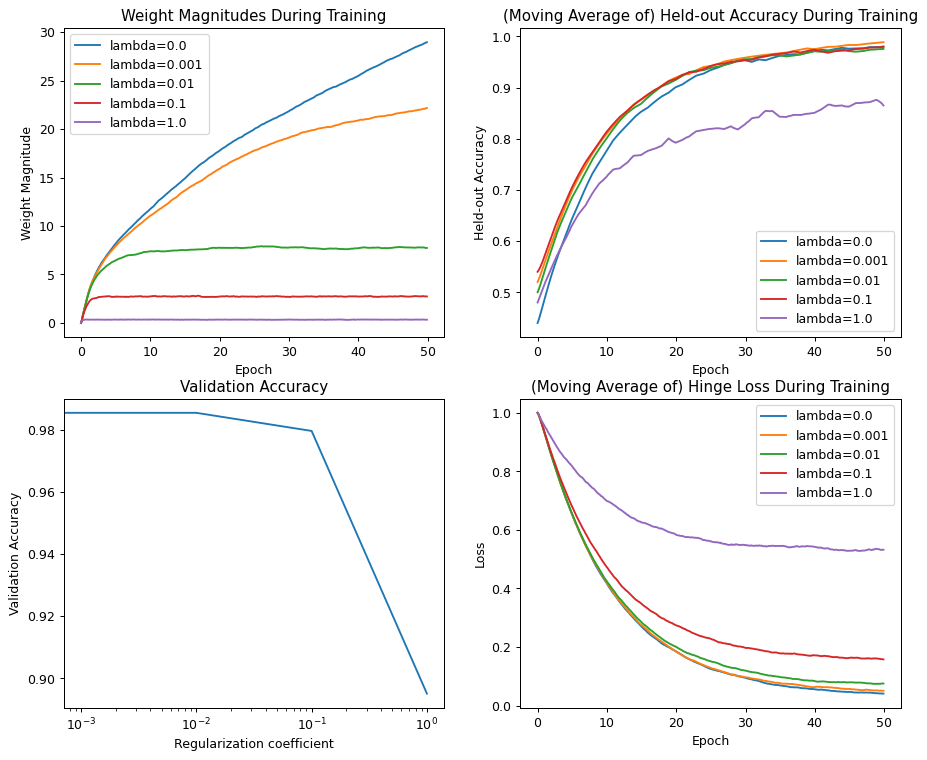

In [150]:
if perform_computation:
    # The noise in the plots were smoothed-out by an exponential moving average filter.
    # If you'd rather see the original plots, you can see the disable noise removal smoothing filters 
    # for each subplot by setting the corresponding smoothing factor to zero.
    generate_plots(training_info_plain_ridge, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.)

In [151]:
w_df = None
if perform_computation:
    w_df = print_weights(training_info_plain_ridge, rounding=4)
w_df

Here are the learned weights for each regularization coefficient:
  * Each row represents a single regularization coefficient.
  * The last two columns represent the weight vector magnitudes.
  * Each of the other columns represent a feature weight. 


,$a_{1}$,$a_{2}$,$a_{3}$,$a_{4}$,$\|a\|_2^2$,$\|a\|_1^1$
$\lambda$,,,,,,
0.0,-2.8326,-3.4223,-3.0394,0.0550,28.9768,9.3493
0.001,-2.5122,-2.9791,-2.6437,0.0477,22.1779,8.1828
0.01,-1.6493,-1.6153,-1.5475,0.0941,7.7329,4.9062
0.1,-1.1227,-0.8700,-0.8399,0.1007,2.7330,2.9333
1.0,-0.5336,-0.2482,-0.0166,-0.0303,0.3475,0.8287


In [152]:
if perform_computation:
    get_test_accuracy(test_features_pr, test_labels_pr, training_info_plain_ridge)

Best lambda was chosen to be 0.0
The resulting test accuracy was 98.251 %


The weight magnitude plot in this problem is showing $||a||_2^2 = \sum_{j=1}^d a_j^2$ since we're using Ridge regularization. Here are some questions you may want to think about as food for thought.

1. Does regularization help at all?

2. If regularization did not help, why do you think the reason was?

 * **Hint**: How many features do you have in this problem?
 

### 2.6.2 Lasso Regularization

In [153]:
if perform_computation:
    splitted_data = train_val_test_split(all_features, all_labels, train_frac=0.5, val_frac=0.25)
    
    # The "_pl" variable postfix is short for "plain lasso".
    train_features_pl, train_labels_pl, val_features_pl, val_labels_pl, test_features_pl, test_labels_pl = splitted_data
    
    training_info_plain_lasso = svm_trainer(train_features_pl, train_labels_pl, val_features_pl, val_labels_pl, 
                                            heldout_size=50,batch_size=32, num_epochs=50, num_steps=300, 
                                            eval_interval = 30, eta_tuner = lambda epoch: 1./(0.01 * epoch + 50.),
                                            lambda_list=[0., 1e-3, 1e-2, 1e-1, 1e0], 
                                            regularization='lasso')

....................................................................................................
lambda=0.0 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.001 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.01 yielded a validation accuracy of 98.542 %
....................................................................................................
lambda=0.1 yielded a validation accuracy of 97.959 %
....................................................................................................
lambda=1.0 yielded a validation accuracy of 55.394 %


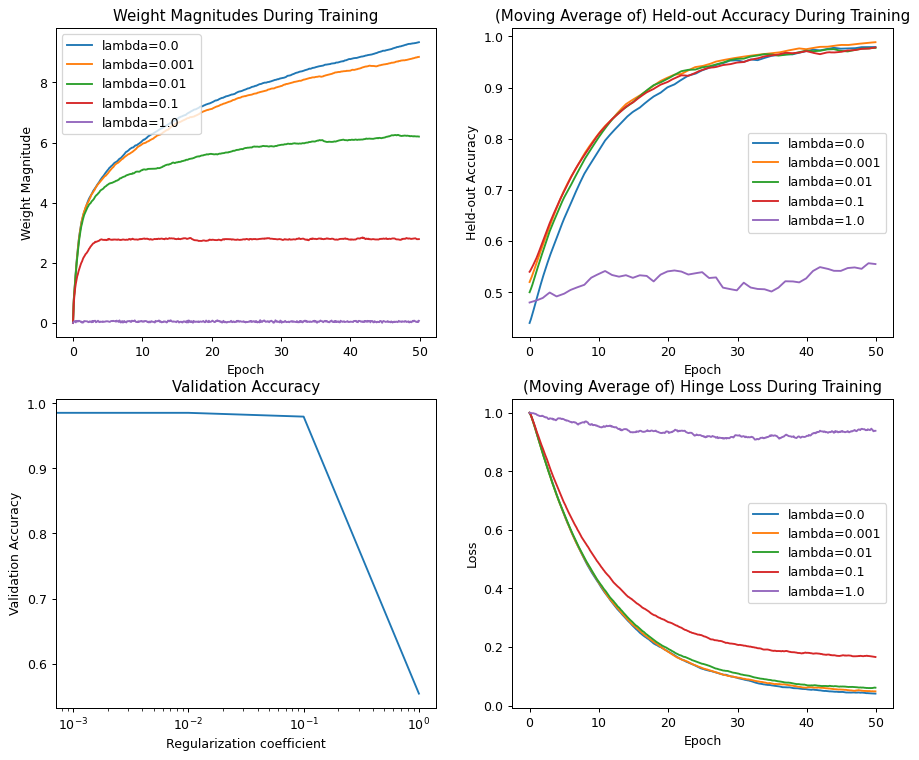

In [154]:
if perform_computation:
    generate_plots(training_info_plain_lasso, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.)

In [155]:
if perform_computation:
    get_test_accuracy(test_features_pl, test_labels_pl, training_info_plain_lasso)

Best lambda was chosen to be 0.0
The resulting test accuracy was 98.251 %


In [156]:
w_df = None
if perform_computation:
    w_df = print_weights(training_info_plain_lasso, rounding=4)
w_df

Here are the learned weights for each regularization coefficient:
  * Each row represents a single regularization coefficient.
  * The last two columns represent the weight vector magnitudes.
  * Each of the other columns represent a feature weight. 


,$a_{1}$,$a_{2}$,$a_{3}$,$a_{4}$,$\|a\|_2^2$,$\|a\|_1^1$
$\lambda$,,,,,,
0.0,-2.8326,-3.4223,-3.0394,0.0550,28.9768,9.3493
0.001,-2.7060,-3.2450,-2.8959,0.0083,26.2388,8.8552
0.01,-1.8677,-2.3005,-2.0161,0.0259,12.8460,6.2102
0.1,-1.0927,-0.8842,-0.8062,-0.0016,2.6258,2.7847
1.0,-0.0260,0.0077,0.0150,-0.0076,0.0010,0.0563


Some other questions that can be some food for thought:

1. Did Lasso regularization help at all in this setting?

2. Did small lasso regularization offer any benefir compared to small ridge regularization?

3. Did large lasso regularization do better than large ridge regularization?

  * **Hint**: Why do you think $\lambda=1$ acted more "aggressively" (i.e., supressed the weights more) with Lasso regularization than Ridge regularization?

# 3. Bank Note Authentication Problem With Induced Noise

In many applied learning tasks, the data set includes a lot of raw measurements (i.e., features), which may not be releavant to the final goal of classification. Trying to identify and exclude such "useless" features may not be an easy job, and would be task-specific, may require a lot of expert knowledge for identification, and would not be easy to automate (which is contrary to the whole point of machine learning). 

To see in practice the phenomenon that irrelevant features make the problem more high-dimensional and therefore challenging, we will add a lot of "useless" features to the bank note authentication dataset we had. More precisely, 5000 random Gaussian Noise features will be concatenated to the original data set to "confuse" the learning model. Philosophically speaking, putting any weight other than zero towards these noise features when making decisions would hurt the overall testing performance of the model. However, the models are still free to put non-zero weights on such features.

Notice that this is not an additive noise to the features, and the "useful" information for making decisions will be untouched (i.e., the 4 original features are still included plainly without any modification). Therefore, one would expect a robust classifier to still be able to produce the same classification quality and ignore the noise features.

## 3.1 Ridge Regularization

In [157]:
if perform_computation: 
    all_features_noised = np.concatenate([all_features, np_random.randn(all_features.shape[0], 5000)], axis=1)
    
    splitted_data = train_val_test_split(all_features_noised, all_labels, train_frac=0.5, val_frac=0.25)
    
    # The "_nr" variable postfix is short for "noisy ridge".
    train_features_nr, train_labels_nr, val_features_nr, val_labels_nr, test_features_nr, test_labels_nr = splitted_data
    
    training_info_noisy_ridge = svm_trainer(train_features_nr, train_labels_nr, val_features_nr, val_labels_nr,
                                            batch_size=32, num_epochs=50, num_steps=300, eval_interval=30, 
                                            eta_tuner = lambda epoch: 1./(0.2 * epoch + 1000.),
                                            lambda_list = [0., 1e-3, 1e-2, 1e-1, 1e0], 
                                            regularization='ridge')

....................................................................................................
lambda=0.0 yielded a validation accuracy of 60.350 %
....................................................................................................
lambda=0.001 yielded a validation accuracy of 60.641 %
....................................................................................................
lambda=0.01 yielded a validation accuracy of 61.224 %
....................................................................................................
lambda=0.1 yielded a validation accuracy of 60.350 %
....................................................................................................
lambda=1.0 yielded a validation accuracy of 60.350 %


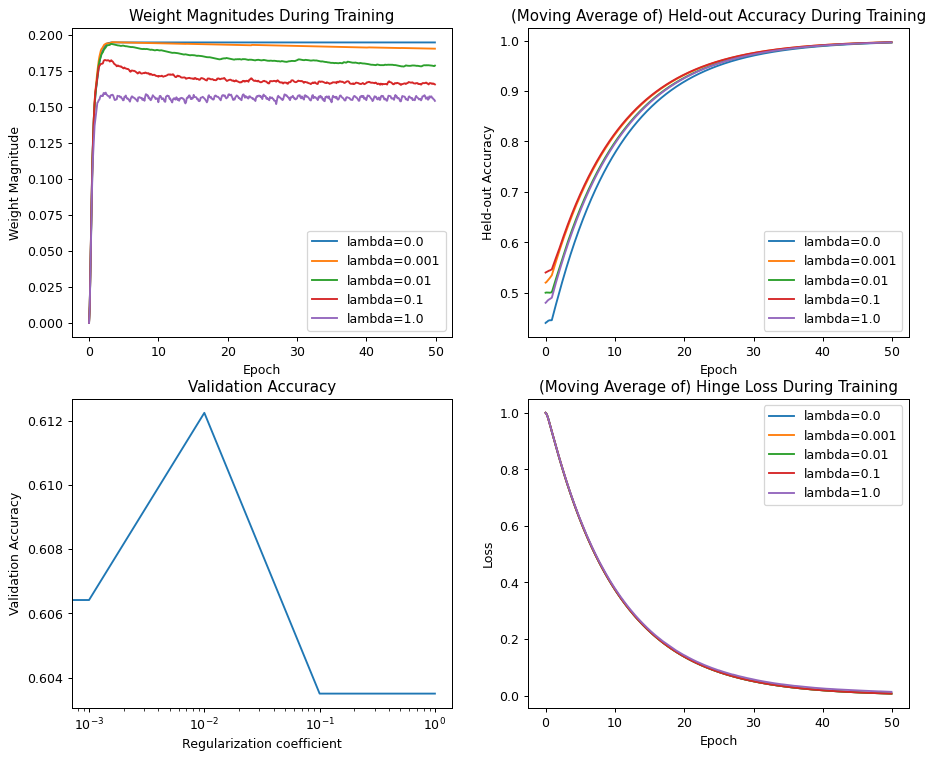

In [158]:
if perform_computation:
    generate_plots(training_info_noisy_ridge, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.)

In [159]:
w_df = None
if perform_computation:
    w_df = print_weights(training_info_noisy_ridge, rounding=4)
    print('  * The non-noise features are the first four features.')
w_df

Here are the learned weights for each regularization coefficient:
  * Each row represents a single regularization coefficient.
  * The last two columns represent the weight vector magnitudes.
  * Each of the other columns represent a feature weight. 
  * The non-noise features are the first four features.


,$a_{1}$,$a_{2}$,$a_{3}$,$a_{4}$,$a_{5}$,$a_{6}$,$a_{7}$,$a_{8}$,$\cdots$,$a_{5002}$,$a_{5003}$,$a_{5004}$,$\|a\|_2^2$,$\|a\|_1^1$
$\lambda$,,,,,,,,,,,,,,
0.0,-0.1141,-0.0634,0.0138,-0.0015,0.0061,0.0015,-0.0077,-0.0206,$\cdots$,0.0006,0.0047,0.0026,0.1949,23.7218
0.001,-0.1128,-0.0622,0.0136,-0.0014,0.0060,0.0021,-0.0073,-0.0199,$\cdots$,-0.0008,0.0062,0.0021,0.1905,23.4538
0.01,-0.1089,-0.0598,0.0124,-0.0016,0.0061,0.0015,-0.0081,-0.0204,$\cdots$,-0.0001,0.0061,0.0020,0.1787,22.7324
0.1,-0.1050,-0.0566,0.0102,-0.0021,0.0060,0.0014,-0.0068,-0.0186,$\cdots$,-0.0008,0.0058,0.0021,0.1655,21.8736
1.0,-0.1017,-0.0547,0.0103,-0.0024,0.0055,0.0018,-0.0067,-0.0178,$\cdots$,-0.0009,0.0056,0.0019,0.1540,21.1044


In [160]:
if perform_computation:
    get_test_accuracy(test_features_nr, test_labels_nr, training_info_noisy_ridge)

Best lambda was chosen to be 0.01
The resulting test accuracy was 63.265 %


Some observational questions:

1. Does SVM without any regularization work on this problem?

  * In other words, how different is SVM performing from a random coin toss?


2. Did Ridge Regularization help?

  * If so, by what margin? Is it significant?

## 3.2 Lasso Regularization

In [161]:
if perform_computation: 
    all_features_noised = np.concatenate([all_features, np_random.randn(all_features.shape[0], 5000)], axis=1)
    
    splitted_data = train_val_test_split(all_features_noised, all_labels, train_frac=0.5, val_frac=0.25)
    
    # The "_nl" variable postfix is short for "noisy lasso".
    train_features_nl, train_labels_nl, val_features_nl, val_labels_nl, test_features_nl, test_labels_nl = splitted_data
    
    training_info_noisy_lasso = svm_trainer(train_features_nl, train_labels_nl, val_features_nl, val_labels_nl,
                                            batch_size=32, num_epochs=50, num_steps=300, eval_interval=30, 
                                            eta_tuner = lambda epoch: 1./(0.2 * epoch + 1000.),
                                            lambda_list = [0., 1e-3, 1e-2, 1e-1, 1e0], 
                                            regularization='lasso')

....................................................................................................
lambda=0.0 yielded a validation accuracy of 58.892 %
....................................................................................................
lambda=0.001 yielded a validation accuracy of 69.096 %
....................................................................................................
lambda=0.01 yielded a validation accuracy of 87.755 %
....................................................................................................
lambda=0.1 yielded a validation accuracy of 97.376 %
....................................................................................................
lambda=1.0 yielded a validation accuracy of 55.394 %


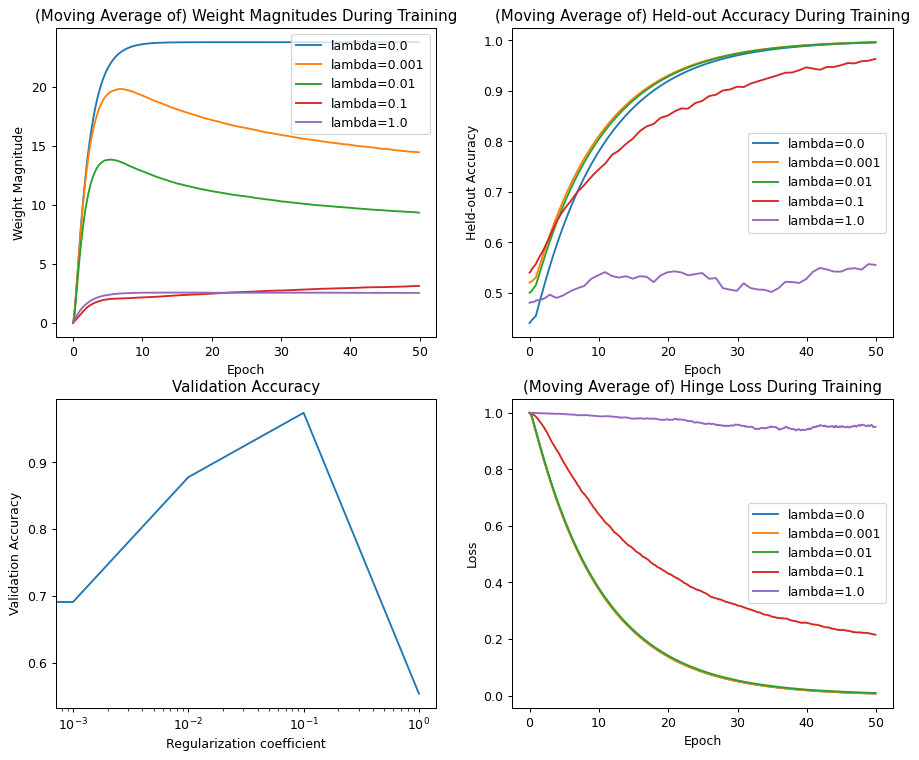

In [162]:
if perform_computation:
    generate_plots(training_info_noisy_lasso, heldout_acc_smoothing=0.99, loss_smoothing=0.99, weight_smoothing=0.95)

In [163]:
w_df = None
if perform_computation:
    w_df = print_weights(training_info_noisy_lasso, rounding=4)
    print('  * The non-noise features are the first four features.')
w_df

Here are the learned weights for each regularization coefficient:
  * Each row represents a single regularization coefficient.
  * The last two columns represent the weight vector magnitudes.
  * Each of the other columns represent a feature weight. 
  * The non-noise features are the first four features.


,$a_{1}$,$a_{2}$,$a_{3}$,$a_{4}$,$a_{5}$,$a_{6}$,$a_{7}$,$a_{8}$,$\cdots$,$a_{5002}$,$a_{5003}$,$a_{5004}$,$\|a\|_2^2$,$\|a\|_1^1$
$\lambda$,,,,,,,,,,,,,,
0.0,-0.1135,-0.0634,0.0150,-0.0008,0.0055,-0.0020,-0.0030,-0.0032,$\cdots$,-0.0010,-0.0108,0.0117,0.1924,23.8062
0.001,-0.2389,-0.1264,-0.0037,0.0000,0.0005,-0.0000,0.0004,-0.0001,$\cdots$,0.0003,-0.0120,0.0134,0.2297,14.2266
0.01,-0.6694,-0.4016,-0.2353,0.0030,0.0004,0.0004,0.0005,0.0000,$\cdots$,-0.0001,-0.0114,-0.0001,0.8092,9.2460
0.1,-1.0468,-0.7828,-0.6585,-0.0001,0.0002,0.0000,0.0005,-0.0000,$\cdots$,-0.0001,-0.0002,0.0000,2.1423,3.1682
1.0,-0.0006,-0.0000,0.0004,0.0010,0.0009,-0.0006,-0.0003,0.0007,$\cdots$,0.0004,0.0007,0.0005,0.0018,2.5644


In [164]:
if perform_computation:
    get_test_accuracy(test_features_nl, test_labels_nl, training_info_noisy_lasso)

Best lambda was chosen to be 0.1
The resulting test accuracy was 96.793 %


1. Did Lasso regularization help in this scenario?

2. If so, why did Lasso help with noisy features? Why didn't Ridge do so?

* **Hint**: In the weights table above, a look at the weights, the corresponding regularization norms, and then making a comparison between the last two trainings (i.e., Ridge vs. Lasso regularization trainings) is useful. 

  * Try and justify what you observe. 
  
  * Which regularization coefficient/scheme produced the most "sensible" set of weights? Why?

## 3.3 SVMLight

In the noisy features scenario, to get the SVM model to train properly using stochastic gradient descent, the learning rate sequences were modified from the previous part.

Ususally tunning such hyper-parameters can play a significant role in the method's final performance. This hyper-parameter tunning process can be extremely difficult and require a lot of expert-intervention.

SVMLight has some nice default hyper-parameters and search procedures set that were benchmarked and thoughtfully picked by its designers. If you'd rather not spending any time tunning hyper-parameters for whatever reason, and just want to get a feeling about a reasonable baseline, checking such carefully written libraries may be a good idea. 

For the sake of comparison, let's see how SVMLight is doing without any intervention.

In [165]:
if perform_computation:
    from sklearn.datasets import dump_svmlight_file
    dump_svmlight_file(train_features_nl, train_labels_nl, 'training_feats.data', 
                       zero_based=False, comment=None, query_id=None, multilabel=False)
    
    !chmod +x ./svmlight/svm_learn
    from subprocess import Popen, PIPE
    process = Popen(["../SGDSVM-lib/svmlight/svm_learn", "./training_feats.data", "svm_model.txt"], stdout=PIPE, stderr=PIPE)
    stdout, stderr = process.communicate()
    print(stdout.decode("utf-8"))

chmod: cannot access './svmlight/svm_learn': No such file or directory
Scanning examples...done
Reading examples into memory...100..200..300..400..500..600..OK. (686 examples read)
Setting default regularization parameter C=0.0002
Optimizing....................................................................................................................................................................................................................................done. (229 iterations)
Optimization finished (1 misclassified, maxdiff=0.00098).
Runtime in cpu-seconds: 2.09
Number of SV: 640 (including 119 at upper bound)
L1 loss: loss=21.71678
Norm of weight vector: |w|=0.27693
Norm of longest example vector: |x|=75.32429
Estimated VCdim of classifier: VCdim<=434.69867
Computing XiAlpha-estimates...done
Runtime for XiAlpha-estimates in cpu-seconds: 0.01
XiAlpha-estimate of the error: error<=24.64% (rho=1.00,depth=0)
XiAlpha-estimate of the recall: recall=>71.84% (rho=1.00,depth=0)
XiAlp

In [166]:
if perform_computation:
    from svm2weight import get_svmlight_weights
    
    def svmlight_classifier(train_features):
        return (train_features @ svm_weights - thresh).reshape(-1) >= 0.
    
    svm_weights, thresh = get_svmlight_weights('svm_model.txt', printOutput=False)
    
    train_pred = 2*(svmlight_classifier(train_features_nl))-1
    test_pred = 2*(svmlight_classifier(test_features_nl))-1

    train_acc = (train_pred==train_labels_nl).mean()
    test_acc = (test_pred==test_labels_nl).mean()
    print(f'The training accuracy of your trained model is %.3f'%(train_acc*100) + '%')
    print(f'The testing accuracy of your trained model is %.3f'%(test_acc*100) + '%')

The training accuracy of your trained model is 99.854%
The testing accuracy of your trained model is 91.545%


In [167]:
if perform_computation:
    import os
    for file in ['svm_model.txt', 'training_feats.data']:
        if os.path.exists(file):
            os.remove(file)